In [1]:
# import some of the libaries that we will use
import urllib.request
import io
import itertools as it
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import unicodedata
import string

from thefuzz import process
from thefuzz import fuzz

import json

import colorcet as cc
import panel as pn
import panel.widgets as pnw

from translate_app import translate_list_to_dict
import recordlinkage as rl
import missingno as msno
import holoviews as hv
from holoviews import streams
from holoviews.selection import link_selections
from holoviews import opts
import hvplot
import hvplot.pandas
import geoviews as gv
import geopandas as gpd
import cartopy.crs as ccrs
from panel.template import FastListTemplate

In [2]:
pn.extension(template="fast")
hv.extension("bokeh")
gv.extension("bokeh")

In [3]:
pd.set_option("display.max_rows", 200)


def remove_accents(input_str):
    """Function to remove accents from a string.
    It takes as argument a string and returns the same string
    without accents."""
    nfkd_form = (
        unicodedata.normalize("NFKD", input_str).encode("ASCII", "ignore").decode()
    )
    # return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return nfkd_form


remove_accents("résuméö")

'resumeo'

In [4]:
# get the zip file with the data from the link

data_url = (
    "https://storage.googleapis.com/mrprime_dataset/dogs_of_zurich/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [5]:
# Shapefile for Zurich
zurich_shapefile = "../data/zurich_shape_data.zip"

# Get the path to the shapefile within the zip archive
shapefile_path = "zip://" + zurich_shapefile + "!data/stzh.adm_stadtkreise_v.shp"

# Read the shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

In [6]:
# Description of zurich districts
zurich_desc_path = "../data/zurich_districts.csv"
# read in csv as a pandas dataframe
zurich_desc = pd.read_csv(zurich_desc_path)

In [7]:
# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)

In [8]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan, dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [9]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

In [10]:
translated_words = translate_list_to_dict(words_set, project_id="mrprimetranslator")


translated_words

{'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'STADTQUARTIER': 'CITY QUARTER',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'Rassentypenliste I': 'Breed type list I',
 'Rassentypenliste II': 'List of breed types II',
 'ALTER': 'AGE',
 'RASSENTYP': 'BREED TYPE',
 'STADTKREIS': 'CITY CIRCLE',
 'HUNDEFARBE': 'DOG COLOR',
 'GESCHLECHT HUND': 'GENDER DOG',
 'RASSE1': 'BREED1',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED',
 'HUNDERASSENTYP': 'DOG BREED TYPE',
 'roster': 'roster',
 'HUNDERASSE': 'DOG BREED',
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED',
 'HALTER ID': 'HOLDER ID',
 'GESCHLECHT': 'GENDER',
 'Kleinwüchsig': 'Short stature',
 'RASSE2': 'BREED2'}

In [11]:
# translate headers using the translate app
# translated_words = translate_app.translate_list(
#     words_set, project_id="mrprimetranslator"
# )
# translated_words

In [12]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'STADTQUARTIER': 'city_quarter',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'Rassentypenliste_I': 'breed_type_list_i',
 'Rassentypenliste_II': 'list_of_breed_types_ii',
 'ALTER': 'age',
 'RASSENTYP': 'breed_type',
 'STADTKREIS': 'city_circle',
 'HUNDEFARBE': 'dog_color',
 'GESCHLECHT_HUND': 'gender_dog',
 'RASSE1': 'breed1',
 'RASSE1_MISCHLING': 'breed1_mixed_breed',
 'HUNDERASSENTYP': 'dog_breed_type',
 'roster': 'roster',
 'HUNDERASSE': 'dog_breed',
 'RASSE2_MISCHLING': 'breed2_mixed_breed',
 'HALTER_ID': 'holder_id',
 'GESCHLECHT': 'gender',
 'Kleinwüchsig': 'short_stature',
 'RASSE2': 'breed2'}

In [13]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"

In [14]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [15]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [dogs_of_zurich_dfs[0], dogs_of_zurich_dfs[1], dogs_of_zurich_dfs[2]], axis=0
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holder_id           21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [16]:
display(dog_owner_df.sample(3))
dog_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
5348,119830,31-40,w,2.0,24.0,Labrador Retriever,Mischling,NaN,NaN,I,2005,w,braun,20151001hundehalter.csv
6248,130202,51-60,w,7.0,74.0,Malinois,NaN,Appenzeller,NaN,I,2009,w,choco,20170308hundehalter.csv
1429,86331,41-50,m,11.0,119.0,Mischling gross,NaN,NaN,NaN,I,2014,w,schwarz/beige,20151001hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
293,Schweizer Sennenhund,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
224,Mischling gross,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
171,Irish Terrier,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv


<Axes: >

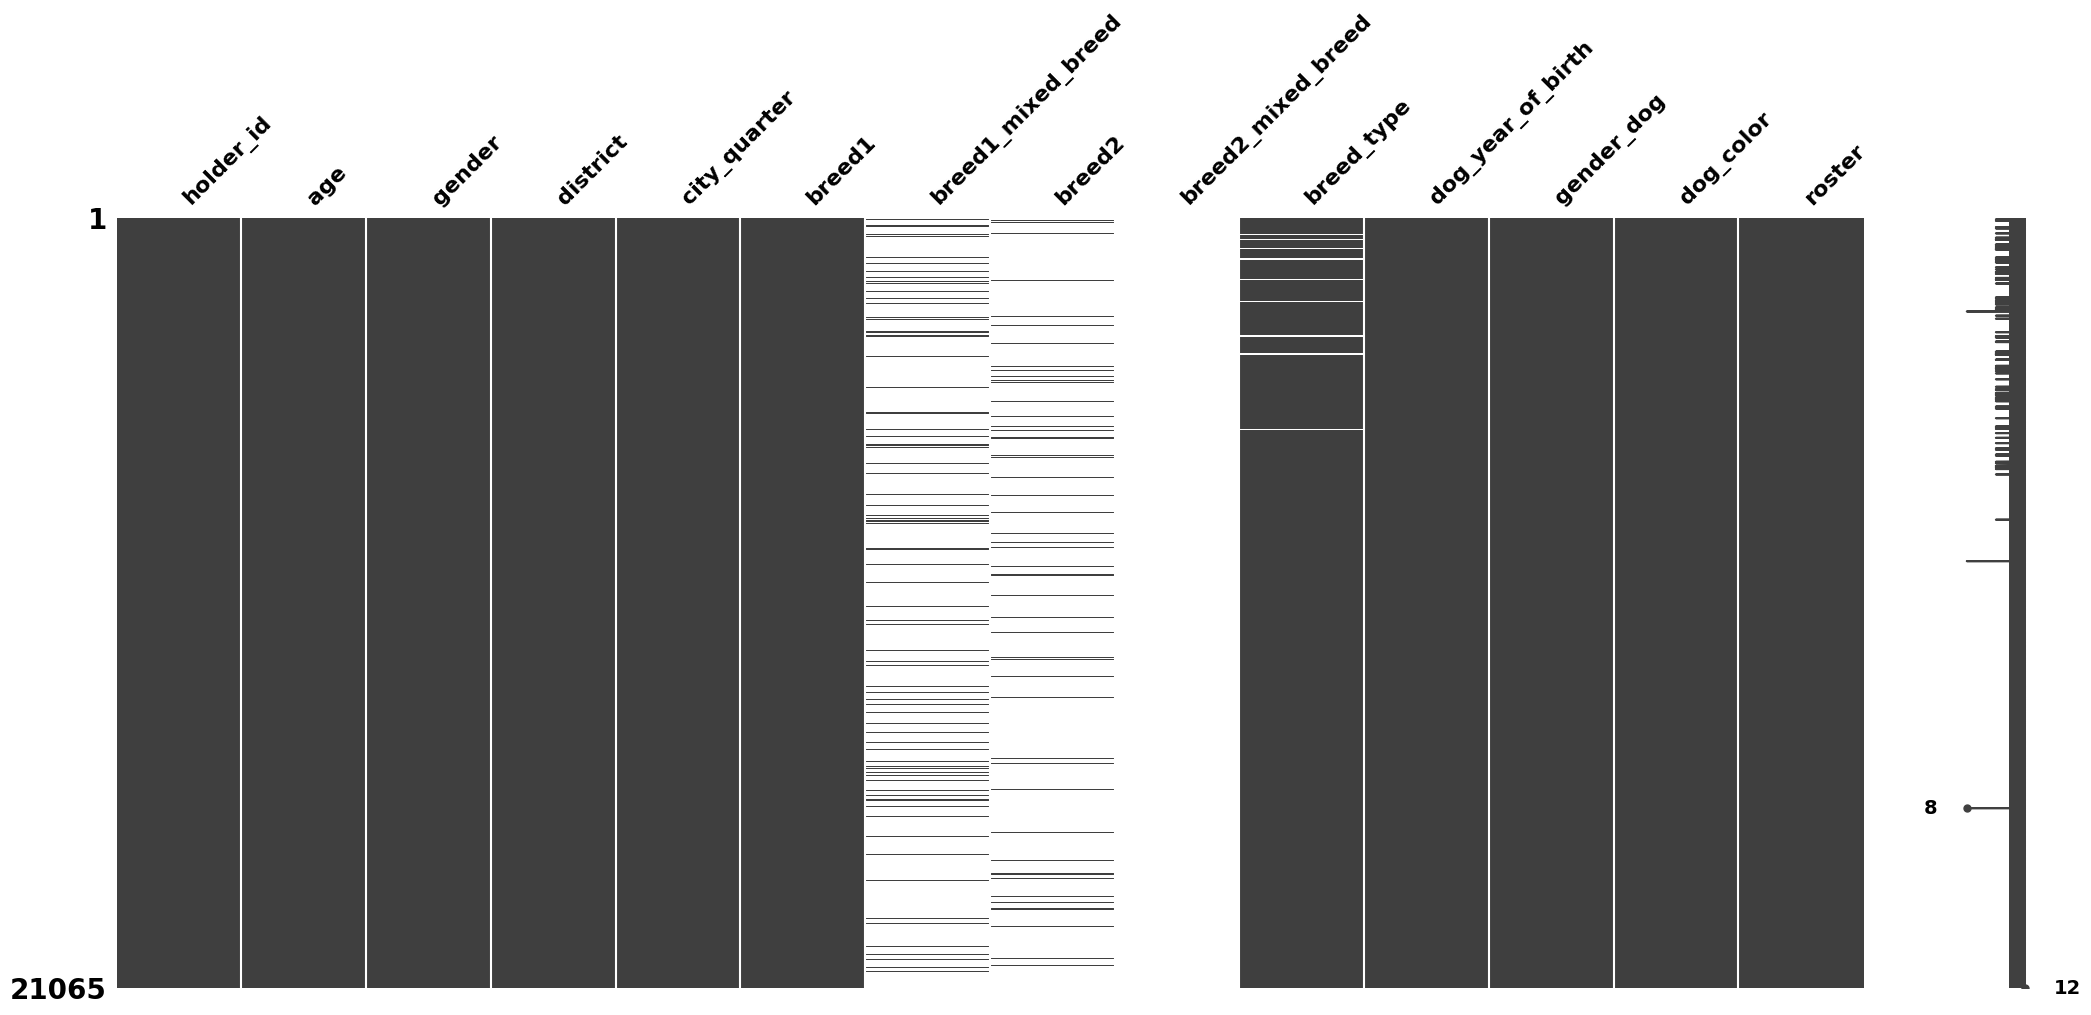

In [17]:
msno.matrix(dog_owner_df)

In [18]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

<Axes: >

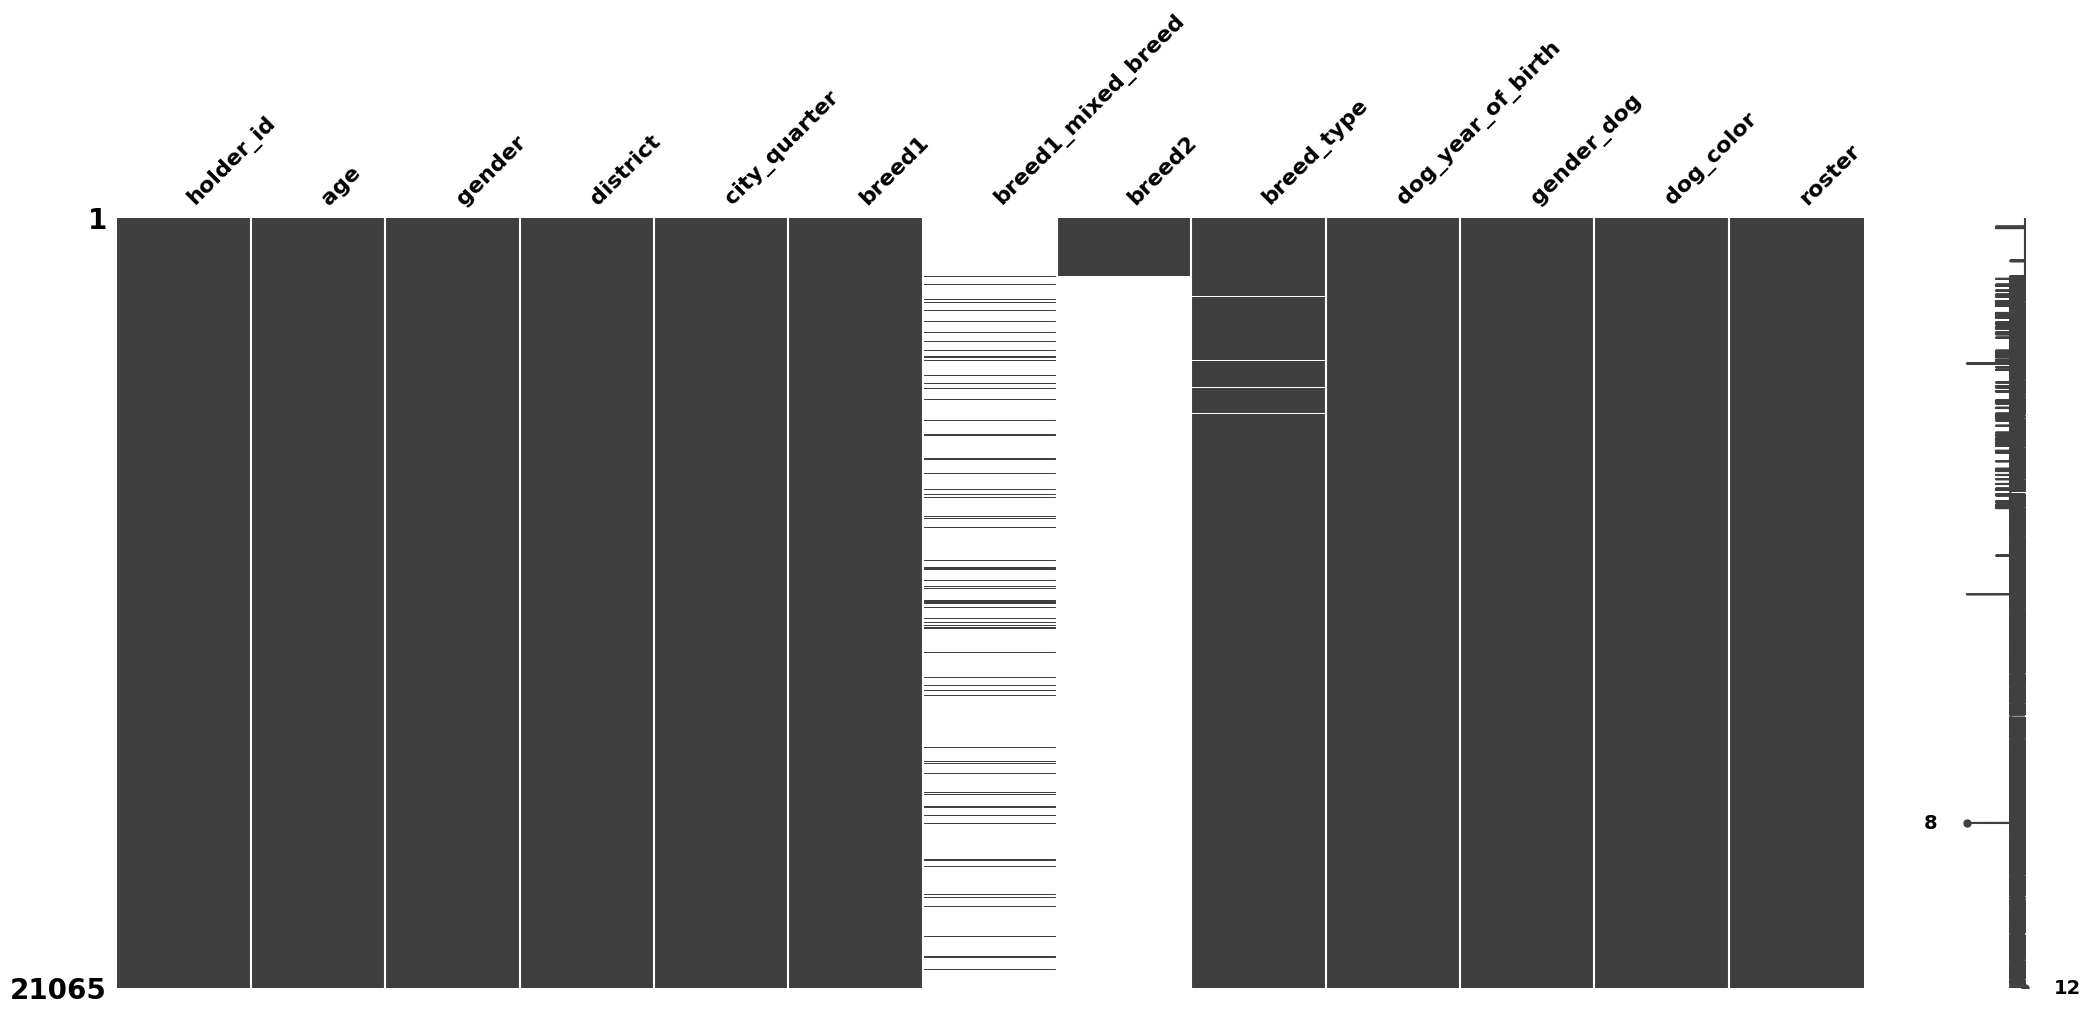

In [19]:
msno.matrix(dog_owner_df.sort_values(by=["breed2"]))

In [20]:
# reset index
dog_owner_df = dog_owner_df.reset_index(drop=True)
# make the district column a category
dog_owner_df["district"] = dog_owner_df["district"].astype("category")

# make all the breed columns lowercase
dog_owner_df["breed1"] = dog_owner_df["breed1"].str.lower()
dog_owner_df["breed2"] = dog_owner_df["breed2"].str.lower()
dog_owner_df["breed1_mixed_breed"] = dog_owner_df["breed1_mixed_breed"].str.lower()


# take the first 4 char of roster only and make it an ordered category colummn
dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]
dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)


# add a column with the first year the owner appeared in the roster
dog_owner_df["first_appearance"] = dog_owner_df.groupby("holder_id")[
    "roster"
].transform("min")

# add column for the numberr of appearances in the roster
dog_owner_df["appearances"] = dog_owner_df.groupby("holder_id")["roster"].transform(
    "nunique"
)

# add a column with the number of dogs per owner
dog_owner_df["dog_count"] = dog_owner_df.groupby(["holder_id", "roster"])[
    "holder_id"
].transform("size")

dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
7145,80011,41-50,w,12.0,123.0,jura laufhund,mischling,NaN,I,2003,m,schwarz/braun/weiss,2016,2015,3,4
17576,107493,61-70,w,3.0,31.0,chihuahua,NaN,mops,K,2010,w,braun,2017,2015,3,2
16137,90193,51-60,w,10.0,102.0,chihuahua,NaN,NaN,K,2007,m,creme,2017,2015,3,1


Dog with a year of birth after the roster year

In [21]:
# get the holder_id of the bad entries and observe other entries with the same holder_id
bad_entry_holder_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["holder_id"]


dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

# dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].index

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
4543,111954,41-50,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2015,2015,2,1
11296,111954,51-60,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2016,2015,2,1
5608,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2015,2015,3,1
12282,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2016,2015,3,1
18798,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2017,2015,3,1


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [22]:
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id)
].index

dog_owner_df.drop(bad_entry_index, inplace=True)

dog_owner_df.info()

(21065, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21060 non-null  int64   
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_appearance    21060 non-null  category
 14  appearances         21060 non-null  int64   
 15  dog_count           21060 non-null  

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [23]:
# get the holder_id of the bad entries
bad_entry_holder_id = dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990][
    "holder_id"
]

# isolate entries from these holder_ids and group them by holder_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)]
    .sort_values(by="holder_id")
    .groupby("holder_id")
)

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,1980,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,8,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,1,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,1962,m,braun/schwarz,2015,2015,3,1


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for th elater rosters. Luckly these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it.

In [24]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2015,2015,3,1


In [25]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(
    dog_owner_df[dog_owner_df["holder_id"] == 129251].index
)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["holder_id"]

Series([], Name: holder_id, dtype: int64)

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [26]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)
dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age
14777,83866,51-60,w,9.0,92.0,mops,NaN,NaN,K,2008,m,beige/schwarz,2017,2015,3,1,10
8016,84696,61-70,w,7.0,71.0,labrador retriever,NaN,NaN,I,2009,m,braun,2016,2015,2,1,8
13545,128442,21-30,m,9.0,92.0,jack russel terrier,NaN,NaN,K,2014,m,weiss/braun,2016,2015,3,1,3


In [27]:
dog_owner_df["dog_age"].describe()

count    21059.000000
mean         8.021226
std          4.107721
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         23.000000
Name: dog_age, dtype: float64

In [28]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age
1348,85988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2015,2015,2,1,15
2556,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2015,2015,3,1,18
8253,85988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2016,2015,2,1,16
9387,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2016,2015,3,1,19
16144,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2017,2015,3,1,20


(21054, 17)

In [29]:
# owners each year
owner_2015 = set(dog_owner_df[dog_owner_df["roster"] == "2015"]["holder_id"])
owner_2016 = set(dog_owner_df[dog_owner_df["roster"] == "2016"]["holder_id"])
owner_2017 = set(dog_owner_df[dog_owner_df["roster"] == "2017"]["holder_id"])

print(f"{len(owner_2015)} initial owners in 2015")
# constant owners for all 3 years
new_2016 = owner_2016.difference(owner_2015)
returning_2016 = owner_2016.intersection(owner_2015)
left_2016 = owner_2015.difference(owner_2016)
print(
    f"{len(new_2016)} new owners in 2016 and {len(returning_2016)} returning owners and {len(left_2016)} owners left in 2016"
)

new_2017 = owner_2017.difference(owner_2015.union(owner_2016))
returning_2017 = owner_2017.intersection(owner_2015.union(owner_2016))
left_2017 = owner_2016.difference(owner_2017)
print(
    f"{len(new_2017)} new owners in 2017 and {len(returning_2017)} returning owners and {len(left_2017)} owners left in 2017"
)

constistent_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constistent_owners)} constant owners")
#
# see if any owners owned in 2015 and 2017, but not 2016
gap_owners = owner_2015.intersection(owner_2017).difference(owner_2016)
print(f"{len(gap_owners)} owners with a gap year")

6312 initial owners in 2015
434 new owners in 2016 and 5836 returning owners and 476 owners left in 2016
975 new owners in 2017 and 5471 returning owners and 830 owners left in 2017
5074 constant owners
31 owners with a gap year


In [30]:
def get_new_and_left_df(dog_owner_df, new_owners, left_owners, year):
    # Get the rows of the new owners and left owners for the year
    new_df = dog_owner_df[dog_owner_df["holder_id"].isin(new_owners)]
    left_df = dog_owner_df[dog_owner_df["holder_id"].isin(left_owners)]

    # Create a dataframe with the list of dog breeds, the number that left and the number that joined
    new_breed_df = (
        new_df["breed1"]
        .value_counts()
        .reset_index()
        .rename(columns={"index": "breed", "breed1": f"joined_{year}"})
    )
    left_breed_df = (
        left_df["breed1"]
        .value_counts()
        .reset_index()
        .rename(columns={"index": "breed", "breed1": f"left_{year}"})
    )

    # Join the two dataframes
    joined_df = pd.merge(
        left_breed_df,
        new_breed_df,
        on="breed",
        how="outer",
    )

    # Fill the NaN values with 0
    joined_df.fillna(0, inplace=True)

    return joined_df


# Calculate the new owners for 2015
new_2015 = owner_2015

# Get the dataframe for 2015, 2016 and 2017
joined_left_2015_df = get_new_and_left_df(dog_owner_df, new_2015, set(), 2015)
joined_left_2016_df = get_new_and_left_df(dog_owner_df, new_2016, left_2016, 2016)
joined_left_2017_df = get_new_and_left_df(dog_owner_df, new_2017, left_2017, 2017)


# Join the three dataframes
final_df = (
    pd.merge(joined_left_2015_df, joined_left_2016_df, on="breed", how="outer")
    .merge(joined_left_2017_df, on="breed", how="outer")
    .fillna(0)
    .sort_values(by=["joined_2015", "joined_2016"], ascending=False)
)

final_df.head(30)

,left_2015,breed,joined_2015,left_2016,joined_2016,left_2017,joined_2017
0,0.0,mischling klein,1773.0,52.0,63.0,181.0,69.0
1,0.0,chihuahua,1355.0,45.0,61.0,128.0,81.0
2,0.0,labrador retriever,1212.0,33.0,46.0,118.0,66.0
3,0.0,jack russel terrier,819.0,19.0,33.0,71.0,34.0
4,0.0,yorkshire terrier,791.0,15.0,54.0,53.0,27.0
5,0.0,malteser,526.0,15.0,25.0,32.0,33.0
6,0.0,mops,491.0,7.0,20.0,62.0,20.0
7,0.0,französische bulldogge,464.0,16.0,43.0,50.0,56.0
8,0.0,golden retriever,450.0,23.0,22.0,56.0,19.0
9,0.0,mischling gross,396.0,9.0,51.0,39.0,54.0


In [31]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)


# dog_owner_df.plot(
#     kind="bar",
#     column="age",
#     by="roster",
#     bins=9,
#     figsize=(10, 5),
#     histtype="step",
# )
dog_owner_df.groupby(
    [
        "age",
        "roster",
    ]
).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Owners age distribution each roster",
)

:Bars   [age,roster]   (value)

In [32]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
dog_owner_df

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,age_group
0,126,51-60,m,9.0,92.0,welsh terrier,NaN,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,5,51-60
1,574,61-70,w,2.0,23.0,cairn terrier,NaN,NaN,K,2002,w,brindle,2015,2015,3,1,14,61-70
2,695,41-50,m,6.0,63.0,labrador retriever,NaN,NaN,I,2012,w,braun,2015,2015,3,1,4,41-50
3,893,61-70,w,7.0,71.0,mittelschnauzer,NaN,NaN,I,2010,w,schwarz,2015,2015,3,1,6,61-70
4,1177,51-60,m,10.0,102.0,shih tzu,NaN,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,5,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,135718,31-40,m,9.0,91.0,mischling gross,NaN,NaN,I,2015,w,golden,2017,2017,1,1,3,31-40
21061,135725,31-40,w,7.0,74.0,boxer,NaN,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,2,31-40
21062,135726,11-20,w,11.0,111.0,pinscher,NaN,NaN,K,2016,w,schwarz,2017,2017,1,1,2,11-30
21063,135728,31-40,w,7.0,72.0,whippet,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,2,31-40


In [33]:
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

In [34]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['terrier', 'pudel', 'miniature australien shepard', 'elo',
       'dogo canario', 'schwedischer vallhund', 'spaniel', 'daisy-dog',
       'deutscher jagdterrier', 'biewer yorkshire terrier'], dtype=object)

In [35]:
dog_owner_df.groupby(["breed_type", "roster"]).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Breed type distribution each roster",
)

:Bars   [breed_type,roster]   (value)

In [36]:
pd.set_option("display.max_rows", 100)
bully_breed = dog_owner_df[dog_owner_df.breed_type == "II"]["breed1"].unique().tolist()
dog_owner_df[dog_owner_df.breed1.isin(bully_breed)]
dog_owner_df[dog_owner_df.breed_type == "II"].sort_values(
    by="dog_count", ascending=False
)["holder_id"].nunique()

# plot the number of dogs each year in breed type II
dog_owner_df[dog_owner_df.breed_type == "II"].groupby(["roster"]).size().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Number of dogs each year in breed type II",
)

:Bars   [roster]   (0)

In [37]:
# Find these breeds in the dog_df and get the breed_type from there
dog_df.drop("roster", axis=1, inplace=True)
dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

,dog_breed,dog_breed_type_short,dog_breed_type


In [38]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "holder_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
biewer yorkshire terrier      K              20
daisy-dog                     K               2
deutscher jagdterrier         K               4
dogo canario                  I               7
elo                           I               3
miniature australien shepard  K              14
pudel                         K             216
                              I               5
schwedischer vallhund         K               2
spaniel                       K              13
terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21054 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21054 non-null  int64   
 1   age                 21054 non-null  category
 2   gender              21054 non-null  object  
 3   district            21052 non-null  category
 4   city_quarter        21052 non-null  float64 
 5   breed1              21054 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          21054 non-null  object  
 9   dog_year_of_birth   21054 non-null  int64   
 10  gender_dog          21054 non-null  object  
 11  dog_color           21054 non-null  object  
 12  roster              21054 non-null  category
 13  first_appearance    21054 non-null  category
 14  appearances         21054 non-null  int64   
 15  dog_count           21054 non-null  

In [39]:
missing_district_holder_id = dog_owner_df[dog_owner_df["district"].isna()][
    "holder_id"
].unique()

dog_owner_df[dog_owner_df["holder_id"].isin(missing_district_holder_id)]

# drop these missing rows with no district info
dog_owner_df.dropna(subset=["district"], inplace=True)

dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21052 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21052 non-null  int64   
 1   age                 21052 non-null  category
 2   gender              21052 non-null  object  
 3   district            21052 non-null  category
 4   city_quarter        21052 non-null  float64 
 5   breed1              21052 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1588 non-null   object  
 8   breed_type          21052 non-null  object  
 9   dog_year_of_birth   21052 non-null  int64   
 10  gender_dog          21052 non-null  object  
 11  dog_color           21052 non-null  object  
 12  roster              21052 non-null  category
 13  first_appearance    21052 non-null  category
 14  appearances         21052 non-null  int64   
 15  dog_count           21052 non-null  

In [40]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,age_group,age_range
6770,127437,51-60,w,10.0,102.0,english springer spaniel,NaN,NaN,I,2015,w,schwarz/weiss,2015,2015,3,1,1,51-60,50s
12045,119851,51-60,w,11.0,115.0,pekingese,mischling,NaN,K,2001,w,braun/schwarz,2016,2015,3,3,16,51-60,50s
8721,88012,51-60,m,1.0,12.0,irish terrier,NaN,NaN,I,2003,m,rot,2016,2015,2,1,14,51-60,50s


In [41]:
dog_owner_df["breed1_mixed_breed"].unique()
dog_owner_df["breed1_mixed_breed"].nunique()
dog_owner_df[breed_columns].describe()
# dog_df["dog_breed"].unique()
dog_owner_df["breed1"].dropna().unique().tolist()

['welsh terrier',
 'cairn terrier',
 'labrador retriever',
 'mittelschnauzer',
 'shih tzu',
 'dackel',
 'bichon frisé',
 'zwergdackel',
 'bergamasker',
 'border collie',
 'pinscher',
 'chihuahua',
 'west highland white terrier',
 'mischling klein',
 'golden retriever',
 'weimaraner',
 'tibetan spaniel',
 'leonberger',
 'shiba inu',
 'beagle',
 'lagotto romagnolo',
 'border terrier',
 'magyar viszla',
 'prager rattler',
 'französische bulldogge',
 'cocker spaniel',
 'zwergrauhaardackel',
 'jack russel terrier',
 'mops',
 'staffordshire bull terrier',
 'grosspudel',
 'spitz',
 'englische bulldogge',
 'english springer spaniel',
 'malteser',
 'dobermann',
 'langhaardackel',
 'husky',
 'bolonka zwetna',
 'kleinspitz',
 'toypudel',
 'terrier',
 'berger blanc suisse',
 'zwergpudel',
 'foxterrier',
 'kooiker',
 'mittelpudel',
 'yorkshire terrier',
 'boxer',
 'pudel',
 'belgischer schäfer',
 'deutscher schäfer',
 'berner sennenhund',
 'chow chow',
 'mudi',
 'papillon',
 'dachshund',
 'tibet te

In [42]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan, dog_owner_df["breed1_mixed_breed"].unique())
)
breed_set = set(breed_list1 + breed_list2 + breed_list3)
breed_set = {breed.lower() for breed in breed_set}

display(len(breed_set))
# breed_set
translations_df = pd.DataFrame()
translations_df["breed"] = list(breed_set)
# sort the breeds alphabetically
translations_df.sort_values(by="breed", inplace=True)
translations_df.shape

364

(364, 1)

In [43]:
breed_list1 = sorted(breed_list1)
# breed_list1

#### Run translate app for breeds

In [44]:
translations_df["breed"] = translations_df["breed"].str.lower()
translations_df["translation"] = ""
trans_dict = translate_list_to_dict(translations_df["breed"].tolist())
translations_df["translation"] = translations_df["breed"].map(trans_dict)
translations_df

,breed,translation
307,affenpinscher,affenpinscher
113,afghane,Afghan
121,afghanischer windhund,Afghan hound
30,airedale terrier,airedale terrier
263,akita inu,akita inu
...,...,...
2,zwergpinscher,miniature pinscher
205,zwergpudel,miniature poodle
226,zwergrauhaardackel,miniature gray-haired dachshund
282,zwergschnauzer,miniature schnauzer


In [45]:
# get number of unique breeds in the translation column
translations_df["translation"].nunique()

356

#### Get the AKC breeds saved to disk

In [46]:
# get the dog_breeds dataframe from the data folder


# akc_breeds_df = pd.read_csv("../data/akc_dog_breeds.csv")


# akc_breeds_df = akc_breeds_df.rename(columns={"breed": "akc_breed"})


# fci_breeds_df = pd.read_csv("../data/fci_breeds_trans.csv")

fci_breeds = pd.read_json("../data/fci_breeds.json", orient="records")
akc_breeds = pd.read_json("../data/akc_breeds.json", orient="records")

In [47]:
def fuzzying_match(breed, df, scorer=fuzz.token_set_ratio):
    for i, row in df.iterrows():
        for alt_name in row["alt_names"]:
            if scorer(breed, alt_name) > 90:  # Set threshold
                # print(row["alt_names"])
                return row["breed_en"]
    return None


def apply_fuzzy_matching(df, column, breeds, fuzz_func):
    return df[column].apply(lambda x: fuzzying_match(x, breeds, fuzz_func))

In [48]:
# Create the fci_breed column with NaNs
translations_df["standard"] = np.nan

# List of columns and fuzz functions to apply
columns = ["breed", "translation"]
fuzz_funcs = [
    fuzz.WRatio,
    fuzz.ratio,
    fuzz.partial_ratio,
    fuzz.token_sort_ratio,
    fuzz.token_set_ratio,
]

# Apply each fuzz function to each column
for column in columns:
    for fuzz_func in fuzz_funcs:
        translations_df["standard"] = translations_df["standard"].fillna(
            apply_fuzzy_matching(translations_df, column, fci_breeds, fuzz_func),
        )

translations_df[translations_df["standard"].isna()].shape
translations_df.shape

(364, 3)

In [49]:
translations_df[translations_df["standard"].isna()].head(50)

,breed,translation,standard
214,alano,alano,None
93,altdeutscher hütehund,old german herding dog,None
150,anatolian kangal,Anatolian Kangal,None
300,anatolischer hirtenhund,Anatolian Shepherd Dog,None
294,bardino,bardino,None
199,bichon löwenherz,bichon lionheart,None
354,bobtail,bobtail,None
280,boerboel,boerboel,None
78,bolonka zwetna,bolonka zwetna,None
314,bulgarischer,Bulgarian,None


In [50]:
akc_breeds = akc_breeds[["breed", "alt_names"]]
akc_breeds["breed_en"] = akc_breeds["breed"].copy()
# remove None values from alt_names
akc_breeds["alt_names"] = akc_breeds["alt_names"].apply(lambda x: list(filter(None, x)))
akc_breeds

,breed,alt_names,breed_en
0,australian cattle dog,[australian cattle dog],australian cattle dog
1,australian shepherd,[australian shepherd],australian shepherd
2,bearded collie,"[collie, bearded collie]",bearded collie
3,beauceron,[beauceron],beauceron
4,belgian laekenois,[belgian laekenois],belgian laekenois
...,...,...,...
276,treeing tennessee brindle,[treeing tennessee brindle],treeing tennessee brindle
277,volpino italiano,[volpino italiano],volpino italiano
278,wetterhoun,[wetterhoun],wetterhoun
279,working kelpie,[working kelpie],working kelpie


In [51]:
# Apply each fuzz function to each column
for column in columns:
    for fuzz_func in fuzz_funcs:
        translations_df["standard"] = translations_df["standard"].fillna(
            apply_fuzzy_matching(translations_df, column, akc_breeds, fuzz_func),
        )
translations_df[translations_df["standard"].isna()].shape

(49, 3)

In [52]:
# get an empty column of the dog_owner dataframe and map the fci_breed to the breed1 column

dog_owner_df = dog_owner_df.merge(
    translations_df, how="left", left_on="breed1", right_on="breed"
)
# dog_owner_df[["breed1", "fci_breed"]].sample(10)

In [53]:
translations_df
dog_owner_df.standard.isna().sum()

3119

In [55]:
dog_owner_df[dog_owner_df["breed_type"] == "i"]["breed1"].count()
dog_owner_df[dog_owner_df["breed_type"] == "ii"]["breed1"].count()
dog_owner_df[dog_owner_df["breed_type"] == "k"]["breed1"].unique()

swiss_breeds = list(
    map(
        lambda x: x.lower(),
        [
            "The Greater Swiss",
            "Bernese Mountain Dog",
            "Appenzeller Sennenhund",
            "Entlebucher",
            "Bernese",
            "Bruno Jura",
            "Saint Hubert Jura",
            "Lucerne Hound",
            "Schwyz",
            "White Swiss Shepherd",
            "St. Bernard",
        ],
    )
)

swiss_keywords = set(it.chain.from_iterable(breed.split() for breed in swiss_breeds))


common_words = {"the", "hound", "dog", "white"}

words_to_look_for = swiss_keywords.difference(common_words)
words_to_look_for
# dog_owner_df.loc[dog_owner_df['main_breed'].contains(swiss_breeds), 'breed_type'] = 'swiss'

{'appenzeller',
 'bernard',
 'bernese',
 'bruno',
 'entlebucher',
 'greater',
 'hubert',
 'jura',
 'lucerne',
 'mountain',
 'saint',
 'schwyz',
 'sennenhund',
 'shepherd',
 'st.',
 'swiss'}

In [56]:
# create a new column is_swiss and set it to false
dog_owner_df["is_swiss"] = False


for swiss_breed in swiss_breeds:
    dog_owner_df.loc[
        dog_owner_df["standard"].str.contains(
            swiss_breed, case=False, regex=True, na=False
        ),
        "is_swiss",
    ] = True

# look at the swiss breeds
dog_owner_df[
    dog_owner_df["standard"].str.contains("german", case=False, regex=True, na=False)
]

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,...,dog_count,dog_age,age_group,age_range,breed,translation,standard,mixed_breed,pure_breed,is_swiss
40,6629,51-60,w,4.0,41.0,spitz,mischling,NaN,K,1997,...,1,19,51-60,50s,spitz,pointed,GERMAN SPITZ,True,False,False
65,21828,71-80,w,7.0,74.0,spitz,mischling,NaN,K,2013,...,1,3,71+,70s,spitz,pointed,GERMAN SPITZ,True,False,False
86,55835,61-70,w,8.0,82.0,deutscher schäfer,NaN,NaN,I,2004,...,1,12,61-70,60s,deutscher schäfer,German shepherd,GERMAN SHEPHERD DOG,False,True,False
89,60397,51-60,m,7.0,74.0,deutscher schäfer,NaN,NaN,I,2005,...,1,11,51-60,50s,deutscher schäfer,German shepherd,GERMAN SHEPHERD DOG,False,True,False
117,66151,51-60,m,11.0,115.0,deutscher schäfer,NaN,NaN,I,2008,...,1,8,51-60,50s,deutscher schäfer,German shepherd,GERMAN SHEPHERD DOG,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20938,135028,21-30,w,3.0,31.0,spitz,NaN,NaN,K,2016,...,1,2,11-30,20s,spitz,pointed,GERMAN SPITZ,False,True,False
20974,135278,41-50,w,2.0,21.0,deutscher schäfer,NaN,NaN,I,2016,...,1,2,41-50,40s,deutscher schäfer,German shepherd,GERMAN SHEPHERD DOG,False,True,False
20976,135280,41-50,w,11.0,111.0,spitz,NaN,NaN,K,2016,...,1,2,41-50,40s,spitz,pointed,GERMAN SPITZ,False,True,False
21032,135647,21-30,w,3.0,34.0,spitz,NaN,NaN,K,2016,...,1,2,11-30,20s,spitz,pointed,GERMAN SPITZ,False,True,False


In [103]:
sorted(dog_owner_df["translation"].unique())

['Afghan',
 'Afghan hound',
 'Alaskan malamute',
 'Alpine Dachsbracke',
 'American Staffordshire Terrier',
 'Anatolian Shepherd Dog',
 'Appenzell Mountain dog',
 'Australia Kelpie',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian silky terrier',
 'Australian terriers',
 'Basset Griffon Vendéen',
 'Bavarian mountain hound',
 'Belgian shepherd',
 'Bergamasque',
 'Berger Picard',
 'Berger des Pyrenees',
 'Bernese Mountain Dog',
 'Bolognese',
 'Bordeaux mastiff',
 'Breton',
 'Breton spaniel',
 'Bulgarian mountain dog',
 'Chesapeake Bay Retrievers',
 'Chinese crested hairless dog',
 'Chinese crested powder puff',
 'Chinese foo dog',
 'Chinese powder puff',
 'Cocker spaniel',
 'Czechoslovakian wolfhound',
 'Dachsbracke',
 'Dalmatian',
 'Dutch shepherd',
 'English toy terrier',
 'Entlebuch mountain dog',
 'Finnish lapdog',
 'French bulldog',
 'German Mastiff',
 'German Spitz',
 'German boxer',
 'German hunting terrier',
 'German long-haired shepherd',
 'German pinscher',
 'Germ

In [104]:
dog_owner_df.loc[
    (dog_owner_df["breed1_mixed_breed"].notnull())
    | (dog_owner_df["breed2"].notnull())
    | (dog_owner_df["translation"].str.contains(r"mixed.*", regex=True)),
    "mixed_breed",
] = True
dog_owner_df["mixed_breed"].fillna(False, inplace=True)
dog_owner_df["pure_breed"] = ~dog_owner_df["mixed_breed"]
only_child_dogs = dog_owner_df[dog_owner_df["dog_count"] == 1]

In [105]:
dog_owner_df.sample(20)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,...,age_range,breed,translation,standard,mixed_breed,pure_breed,is_swiss,color1,color2,color3
2594,90602,41-50,w,10.0,102.0,border terrier,NaN,NaN,K,2007,...,40s,border terrier,border terrier,BORDER TERRIER,False,True,False,Gray,brown,None
13762,129976,31-40,m,8.0,81.0,irish terrier,NaN,NaN,I,2007,...,30s,irish terrier,Irish terrier,IRISH TERRIER,False,True,False,blonde colored,None,None
18635,120399,41-50,w,7.0,73.0,yorkshire terrier,NaN,NaN,K,2009,...,40s,yorkshire terrier,yorkshire terrier,YORKSHIRE TERRIER,False,True,False,black,tan,None
4260,108468,31-40,m,11.0,115.0,hovawart,NaN,NaN,I,2007,...,30s,hovawart,hovawart,HOVAWART,False,True,False,black brands,None,None
11915,118729,41-50,w,11.0,119.0,papillon,NaN,NaN,K,2013,...,40s,papillon,papillon,papillon,False,True,False,tricolor,None,None
7261,80760,61-70,w,7.0,74.0,epagneul breton,NaN,NaN,I,2015,...,60s,epagneul breton,epagneul breton,BRITTANY SPANIEL,False,True,False,white,orange,None
436,81448,71-80,w,4.0,41.0,rauhaar dackel,NaN,NaN,K,2007,...,70s,rauhaar dackel,wire-haired dachshund,DACHSHUND,False,True,False,saucy color,None,None
16796,99267,61-70,w,9.0,92.0,rauhaar dackel,mischling,NaN,K,2007,...,60s,rauhaar dackel,wire-haired dachshund,DACHSHUND,True,False,False,grey-brown,None,None
2608,90745,51-60,w,7.0,74.0,beagle,NaN,NaN,K,2007,...,50s,beagle,beagle,BEAGLE,False,True,False,tricolor,None,None
17434,105487,51-60,m,7.0,72.0,labrador retriever,NaN,pudel,I,2010,...,50s,labrador retriever,labrador retrievers,LABRADOR RETRIEVER,True,False,False,light brown,None,None


#### Translate colors

To fix mismatch of German Shepherd breed, we transate the colors and change the rows with the WHITE SWISS SHEPHERD DOG toi the correct breed of GERMAN SHEPHERD DOG.

In [57]:
# make 1 set of all the unique colors
color_set = set()

dog_colors_df = dog_owner_df["dog_color"].str.split("/", expand=True)
dog_colors_list = dog_colors_df.melt().value.unique().tolist()
dog_colors_list = [color for color in dog_colors_list if color is not None]
# dog_colors_list
# get translation for colors
dog_color_dict = translate_list_to_dict(dog_colors_list)

# dog_color_dict = translate_list_to_dict(dog_colors_list)
# dog_color_dict

In [58]:
dog_colors_en = dog_colors_df.applymap(dog_color_dict.get)
dog_colors_en.columns = ["color1", "color2", "color3"]
dog_owner_df = dog_owner_df.merge(dog_colors_en, left_index=True, right_index=True)

In [59]:
dog_owner_df.standard.value_counts().head(20)

CHIHUAHUA                      1497
LABRADOR RETRIEVER             1324
JACK RUSSELL TERRIER           1002
YORKSHIRE TERRIER               901
POODLE                          885
DACHSHUND                       618
MALTESE                         597
FRENCH BULLDOG                  571
PUG                             531
GOLDEN RETRIEVER                491
BORDER COLLIE                   306
WEST HIGHLAND WHITE TERRIER     296
ENGLISH COCKER SPANIEL          291
WHITE SWISS SHEPHERD DOG        280
APPENZELL CATTLE DOG            273
BEAGLE                          262
AFFENPINSCHER                   256
PEKINGESE                       253
GERMAN SHEPHERD DOG             244
MINIATURE PINSCHER              232
Name: standard, dtype: int64

In [60]:
coi = ["breed", "dog_color", "breed1", "breed2", "color1", "color2", "color3"]

german_shephard_tidying = dog_owner_df[
    dog_owner_df["breed1"].str.contains(r"^schäfer", case=False, regex=True, na=False)
][coi]
# check if white in any of the columns and put True in has_white column
german_shephard_tidying["has_white"] = german_shephard_tidying[coi].apply(
    lambda x: "white" in x.values, axis=1
)
# get the indexes of the rows with has_white as False
real_german_shepherd_idx = german_shephard_tidying[
    ~german_shephard_tidying["has_white"]
].index.tolist()

# change the standard column to GERMAN SHEPHERD DOG from WHITE SWISS SHEPHERD DOG
dog_owner_df.loc[real_german_shepherd_idx, "standard"] = "GERMAN SHEPHERD DOG"

In [61]:
# dog_owner_df[
#     dog_owner_df["standard"].str.contains(
#         r"WHITE SWISS", case=False, regex=True, na=False
#     )
# ]

In [62]:
fci_breeds["alt_names"]
swiss_breeds
for swiss_breed in swiss_breeds:
    for i, row in fci_breeds.iterrows():
        for alt_names in row["alt_names"]:
            if swiss_breed in alt_names:
                # print(swiss_breed, row["alt_names"])
                pass


def find_in_alt_names(breed):
    """Function for quicksearch in the alt_names of the fci_breeds dataframe"""
    list_to_return = []
    for i, row in fci_breeds.iterrows():
        names = [name.casefold() for name in row["alt_names"]]
        for alt_names in row["alt_names"]:
            if re.search(breed, alt_names, re.IGNORECASE):
                list_to_return.append(row["alt_names"])
    if len(list_to_return):
        return list_to_return
    return None


find_in_alt_names("hubert")

swiss_breeds_df = pd.DataFrame()
swiss_breeds_df = pd.DataFrame(swiss_breeds, columns=["breed"])
swiss_breeds_df["fuzzy_match"] = None
# find the fuzzy matches for the swiss breeds

for fuzz_func in fuzz_funcs:
    swiss_breeds_df["fuzzy_match"] = swiss_breeds_df["fuzzy_match"].fillna(
        swiss_breeds_df["breed"].apply(
            lambda x: fuzzying_match(x, fci_breeds, fuzz_func)
        )
    )


for fuzz_func in fuzz_funcs:
    swiss_breeds_df["fuzzy_match"] = swiss_breeds_df["fuzzy_match"].fillna(
        swiss_breeds_df["breed"].apply(
            lambda x: fuzzying_match(x, akc_breeds, fuzz_func)
        )
    )

swiss_breeds_df

,breed,fuzzy_match
0,the greater swiss,None
1,bernese mountain dog,BERNESE MOUNTAIN DOG
2,appenzeller sennenhund,APPENZELL CATTLE DOG
3,entlebucher,ENTLEBUCH CATTLE DOG
4,bernese,BERNESE MOUNTAIN DOG
5,bruno jura,None
6,saint hubert jura,None
7,lucerne hound,SWISS HOUND
8,schwyz,SWISS HOUND
9,white swiss shepherd,WHITE SWISS SHEPHERD DOG


In [63]:
dog_owner_df["breed_type"].value_counts()

K     13219
I      7770
II       63
Name: breed_type, dtype: int64

In [64]:
# find_in_alt_names("swiss")
dog_owner_df.standard.value_counts().head(23)

CHIHUAHUA                      1497
LABRADOR RETRIEVER             1324
JACK RUSSELL TERRIER           1002
YORKSHIRE TERRIER               901
POODLE                          885
DACHSHUND                       618
MALTESE                         597
FRENCH BULLDOG                  571
PUG                             531
GOLDEN RETRIEVER                491
GERMAN SHEPHERD DOG             453
BORDER COLLIE                   306
WEST HIGHLAND WHITE TERRIER     296
ENGLISH COCKER SPANIEL          291
APPENZELL CATTLE DOG            273
BEAGLE                          262
AFFENPINSCHER                   256
PEKINGESE                       253
MINIATURE PINSCHER              232
AIREDALE TERRIER                231
BERNESE MOUNTAIN DOG            216
SHIH TZU                        215
HAVANESE                        184
Name: standard, dtype: int64

In [65]:
# dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
# dog_df.to_csv("../data/dog_df.csv", index=False)

#### checkpoint

In [66]:
dog_owner_df[dog_owner_df.standard.isna()]

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,...,age_range,breed,translation,standard,mixed_breed,pure_breed,is_swiss,color1,color2,color3
17,4726,51-60,m,5.0,52.0,mischling klein,NaN,NaN,K,2007,...,50s,mischling klein,mixed breed small,None,False,True,False,black,None,None
23,4908,51-60,m,5.0,51.0,mischling klein,NaN,NaN,K,1999,...,50s,mischling klein,mixed breed small,None,False,True,False,light brown,None,None
24,4908,51-60,m,5.0,51.0,mischling klein,NaN,NaN,K,2000,...,50s,mischling klein,mixed breed small,None,False,True,False,black,brown,white
38,6600,51-60,m,6.0,63.0,mischling klein,NaN,NaN,K,2004,...,50s,mischling klein,mixed breed small,None,False,True,False,brown,None,None
44,12409,61-70,m,9.0,91.0,mischling klein,NaN,NaN,K,2008,...,60s,mischling klein,mixed breed small,None,False,True,False,white,black,brown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21019,135580,21-30,w,11.0,119.0,zwergspitz,NaN,NaN,K,2016,...,20s,zwergspitz,dwarf pointed,None,False,True,False,orange,None,None
21026,135594,41-50,w,3.0,33.0,bolonka zwetna,NaN,NaN,K,2011,...,40s,bolonka zwetna,bolonka zwetna,None,False,True,False,black,white,None
21036,135673,71-80,w,7.0,74.0,bolonka zwetna,NaN,NaN,K,2005,...,70s,bolonka zwetna,bolonka zwetna,None,False,True,False,black,white,None
21039,135685,31-40,w,9.0,92.0,mischling klein,NaN,NaN,K,2005,...,30s,mischling klein,mixed breed small,None,False,True,False,black,None,None


In [67]:
# map the standard unique values to a cmap for consistency
cmap = cc.glasbey_dark
# explicit mapping for the colir to use for each standard breed
explicit_mapping = {
    breed: cmap[i] for i, breed in enumerate(dog_owner_df["standard"].unique())
}

In [68]:
explicit_mapping

{'WELSH TERRIER': '#d60000',
 'CAIRN TERRIER': '#8c3bff',
 'LABRADOR RETRIEVER': '#018700',
 'SCHNAUZER': '#00acc6',
 'SHIH TZU': '#e6a500',
 'DACHSHUND': '#ff7ed1',
 'BICHON FRISE': '#6b004f',
 'BERGAMASCO SHEPHERD DOG': '#573b00',
 'BORDER COLLIE': '#005659',
 'AFFENPINSCHER': '#15e18c',
 'CHIHUAHUA': '#0000dd',
 'WEST HIGHLAND WHITE TERRIER': '#a17569',
 None: '#bcb6ff',
 'GOLDEN RETRIEVER': '#bf03b8',
 'WEIMARANER': '#645472',
 'TIBETAN SPANIEL': '#790000',
 'LEONBERGER': '#0774d8',
 'SHIBA': '#729a7c',
 'BEAGLE': '#ff7752',
 'ROMAGNA WATER DOG': '#004b00',
 'BORDER TERRIER': '#8e7b01',
 'HUNGARIAN WIRE-HAIRED POINTER': '#f2007b',
 'PRAGUE RATTER': '#8eba00',
 'FRENCH BULLDOG': '#a57bb8',
 'ENGLISH COCKER SPANIEL': '#5901a3',
 'JACK RUSSELL TERRIER': '#e2afaf',
 'PUG': '#a03a52',
 'STAFFORDSHIRE BULL TERRIER': '#a1c8c8',
 'POODLE': '#9e4b00',
 'GERMAN SPITZ': '#546744',
 'BULLDOG': '#bac389',
 'ENGLISH SPRINGER SPANIEL': '#5e7b87',
 'MALTESE': '#60383b',
 'DOBERMANN': '#8287ff',
 '

In [69]:
gdf.to_crs(epsg=4326, inplace=True)
zurich_poly = gv.Polygons(gdf).opts(
    projection=ccrs.GOOGLE_MERCATOR,
    tools=["hover"],
    height=500,
    width=800,
    alpha=0.3,
    line_color="gray",
    xaxis=None,
    yaxis=None,
    title="Zurich Districts",
)

# add a basemap
basemap = gv.tile_sources.OSM().opts(alpha=0.3)

basemap * zurich_poly

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (objid,knr,kname)

In [70]:
# dog_owner_df

In [96]:
pn.state.kill_all_servers()
# get the top 6 breeds for the entire dataset
# examine their distribution across each of the districts
top7 = dog_owner_df["standard"].value_counts().head(8).index.tolist()
top7
# construct a heatmap of the top 5 breeds across the districts
df_heatmap = (
    dog_owner_df[dog_owner_df["standard"].isin(top7)]
    .groupby(["standard", "district"])
    .size()
    .unstack()
)
heatmap_opts = dict(
    width=800,
    height=500,
    xlabel="District",
    ylabel="",
    tools=["hover"],
    line_color="white",
    line_width=2,
)
heatmap = hv.HeatMap((df_heatmap.columns, df_heatmap.index, df_heatmap.values))
heatmap.opts(**heatmap_opts)

# group by roster also and see how the distribution changes
df_heatmap2 = (
    dog_owner_df[dog_owner_df["standard"].isin(top7)]
    .groupby(["standard", "district", "roster"])
    .size()
    .reset_index(name="size")
)
display(df_heatmap2)
# Define the widget
roster_slider = pnw.DiscreteSlider(options=["2015", "2016", "2017"], name="Roster")


# Define a function to create a heatmap
def get_heatmap(roster):
    df = df_heatmap2[df_heatmap2["roster"] == roster]
    heatmap = hv.HeatMap(df, ["district", "standard"], "size")
    heatmap.opts(
        **heatmap_opts,
        cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top 5 breeds in {roster}",
    )
    return heatmap


# Bind the widget to the function
dynamic_heatmap = pn.bind(get_heatmap, roster=roster_slider.param.value)

# Create a Panel layout
pn.Row(roster_slider, dynamic_heatmap)

,standard,district,roster,size
0,CHIHUAHUA,1.0,2015,10
1,CHIHUAHUA,1.0,2016,11
2,CHIHUAHUA,1.0,2017,12
3,CHIHUAHUA,2.0,2015,37
4,CHIHUAHUA,2.0,2016,35
...,...,...,...,...
283,YORKSHIRE TERRIER,11.0,2016,72
284,YORKSHIRE TERRIER,11.0,2017,77
285,YORKSHIRE TERRIER,12.0,2015,41
286,YORKSHIRE TERRIER,12.0,2016,40


BokehModel(combine_events=True, render_bundle={'docs_json': {'70efc181-3a76-48b2-97a4-1ec3789d6b99': {'version…

In [97]:
# group by roster and district and get the number of dogs in each district
district_dogs = dog_owner_df.groupby(
    ["roster", "district"]).size().reset_index()
district_dogs.rename(columns={0: "dog_count"}, inplace=True)
# plot a bar chart of the number of dogs in each district groupby roster
# plot the bars for each roster in ta separate row in one layout using holoviews
bars = [
    district_dogs[district_dogs["roster"] == roster]
    .hvplot.bar(
        x="district",
        y="dog_count",
        title=f"Number of dogs in each district in {roster}",
        xlabel="",
        ylabel="Number of dogs",
        tools=["hover"],
        width=600,
        height=300,
    )
    .opts(
        active_tools=["box_zoom"],
    )
    for roster in district_dogs["roster"].unique()
]
hv.Layout(bars).cols(1)
# hv.Bars(district_dogs, ["district", "roster"], "dog_count").opts(
#     stacked=True,
#     width=800,
#     height=500,
#     tools=["hover"],
#     title="Number of dogs in each district",
# )
# district_dogs

:Layout
   .Bars.I   :Bars   [district]   (dog_count)
   .Bars.II  :Bars   [district]   (dog_count)
   .Bars.III :Bars   [district]   (dog_count)

In [100]:
# Group by standard and roster, and calculate the size for each group
df_trend = (
    dog_owner_df[dog_owner_df["standard"].isin(top7)]
    .groupby(["standard", "roster"])
    .size()
    .reset_index(name="size")
)

# Pivot the data to have roster as columns and breeds as index
df_trend_pivot = df_trend.pivot(index="standard", columns="roster", values="size")

# Plot the data
line_plot = df_trend_pivot.T.hvplot(kind="line", legend="right", cmap=explicit_mapping)
dot_plot = df_trend_pivot.T.hvplot.scatter(legend="right")
# line_plot.set_xlabel("Year")
# line_plot.set_ylabel("Count")
line_plot * dot_plot

:Overlay
   .NdOverlay.I  :NdOverlay   [standard]
      :Curve   [roster]   (value)
   .NdOverlay.II :NdOverlay   [standard]
      :Scatter   [roster]   (value)

In [ ]:
# Define the breeds to highlight
highlight_breeds = ["CHIHUAHUA", "FRENCH BULLDOG"]

# Calculate the percentage change for each breed from year to year
df_trend_pivot_pct_change = df_trend_pivot.pct_change(axis="columns")


# Plot the highlighted breeds
highlight_line_plot = df_trend_pivot_pct_change.loc[highlight_breeds].T.hvplot(
    kind="line", legend="right"
)
highlight_dot_plot = df_trend_pivot_pct_change.loc[highlight_breeds].T.hvplot.scatter(
    legend="right"
)

# Plot the other breeds
other_line_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot(
    kind="line", legend="right", color="lightgray"
)
other_dot_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot.scatter(
    legend="right", color="lightgray"
)

# add in the zero like  dotted
zero_line = hv.HLine(0).opts(line_dash="dashed", line_color="lightgray")
# zero_line * line_plot_pct_change * dot_plot_pct_change
# line_plot_pct_change * dot_plot_pct_change

# Combine the plots
zero_line * other_line_plot * other_dot_plot * highlight_line_plot * highlight_dot_plot

:Overlay
   .HLine.I       :HLine   [x,y]
   .NdOverlay.I   :NdOverlay   [standard]
      :Curve   [roster]   (value)
   .NdOverlay.II  :NdOverlay   [standard]
      :Scatter   [roster]   (value)
   .NdOverlay.III :NdOverlay   [standard]
      :Curve   [roster]   (value)
   .NdOverlay.IV  :NdOverlay   [standard]
      :Scatter   [roster]   (value)

In [ ]:
pn.state.kill_all_servers()

# On a map of Zurich, plot the number of dogs in each district
# show any trend is clear like observed with the line plot with the French Bulldog and Chihuahua
# plot the distribution by roster
poly_opts = dict(
    width=1200,
    height=400,
    tools=["hover", "tap", "box_select"],
    line_width=2,
    xaxis=None,
    yaxis=None,
    cmap=explicit_mapping,
    color="standard",
    projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=400,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",  # Breeds
    cmap=explicit_mapping,
    color="standard",
    show_legend=False,
)


z_gdf = gdf.drop(columns=["objid", "kname"]).rename(columns={"knr": "district"})

z_set = gv.Dataset(z_gdf, kdims=["district"])

zurich_poly = gv.Polygons(z_set.data)

# define the function to get the breed counts


def filter_data(roster):
    return dog_owner_df.query("roster==@roster")


def get_polygons(filtered_df, roster_slider, district_slider):
    # Group the data by 'district' and 'breed', then count the number of occurrences
    breed_counts = filtered_df.groupby(["district", "standard"]).size()
    # Use idxmax to find the breed with the highest count in each district
    top_breeds = breed_counts.groupby(level=0).idxmax()
    # Create a DataFrame with the breed and count
    top_breeds_df = breed_counts.loc[top_breeds].reset_index(name="count")
    # Merge the dataframes on the 'district' column
    merged = z_set.data.merge(top_breeds_df, on="district")
    # Create the gv.Polygons object
    return gv.Overlay(
        {
            breed: gv.Polygons(
                merged[merged["standard"] == breed],
                vdims=["standard", "district", "count"],
            )
            for breed in merged["standard"].unique()
        }
    ).opts(
        opts.Polygons(
            **poly_opts,
            fill_alpha=0.3,
            line_color="white",
            # title=f"Zurich | Top breed {roster_slider}",
        )
    )


# define a function to outline the path of the district according to district_slider
def get_district_boundary(district_slider):
    return gv.Polygons(
        z_set.data[z_set.data["district"] == district_slider],
        vdims=["district"],
    ).opts(
        opts.Polygons(
            **poly_opts,
            fill_alpha=0,
            line_color="red",
            # cmap=explicit_mapping,
        )
    )


def get_bar_plot(filtered_data, roster_slider, district_slider):
    """get the top 8 breeds for that roster and plot a bar chart"""
    district_filtered = filtered_data.query("district==@district_slider")
    top8 = district_filtered["standard"].value_counts().head(3).index.tolist()
    breed_counts = (
        district_filtered[district_filtered["standard"].isin(top8)]
        .groupby(["standard", "district"])
        .size()
    )
    breed_counts = breed_counts.reset_index(name="count")
    bars = hv.Bars(breed_counts, kdims=["standard"], vdims=["count"])
    # Create labels
    labels = hv.Labels(breed_counts, kdims=["standard", "count"], vdims=["count"])
    # Combine bars and labels
    plot = bars * labels.opts(
        text_color="black", text_font_size="14pt", text_align="left"
    )
    return plot.opts(
        opts.Bars(
            **bar_opts,
            title=f"Top 8 breeds in {roster_slider} in {district_slider}",
        )
    )


# Define a func to get the snippet on the districts


def get_zurich_desc(district_slider):
    """
    Get the description of a district in Zurich based on the district slider value.
    """
    district_name = zurich_desc[zurich_desc["district"] == district_slider][
        "district_name"
    ].iloc[0]
    description = zurich_desc[zurich_desc["district"] == district_slider]["desc"].iloc[
        0
    ]
    return pn.pane.Markdown(f"## {district_name}\n\n{description}")

In [ ]:
# Define the widget
roster_slider = pnw.DiscreteSlider(options=["2015", "2016", "2017"], name="Roster")

district_slider = pnw.IntSlider(name="District", value=1, start=1, end=12)

# get stream selection
# select_district = streams.Selection1D(source=z_set)


# Filter the data based on the roster value
bound_filtered_df = pn.bind(filter_data, roster=roster_slider.param.value)

# define dynamicMap for polygons
polygons = hv.DynamicMap(
    pn.bind(
        get_polygons,
        filtered_df=bound_filtered_df,
        roster_slider=roster_slider,
        district_slider=district_slider,
    )
)

# district boundary to outline the district slider
district_boundary = hv.DynamicMap(
    pn.bind(
        get_district_boundary,
        district_slider=district_slider,
    )
)


# define dynamicMap for bar plot
bar_plot = hv.DynamicMap(
    pn.bind(
        get_bar_plot,
        filtered_data=bound_filtered_df,
        roster_slider=roster_slider,
        district_slider=district_slider,
    )
)

# define dynamicMap for district description
district_desc = pn.panel(
    pn.bind(get_zurich_desc, district_slider=district_slider), width=400
)


polygons_with_base = basemap * polygons * district_boundary
polygon_panel = pn.panel(polygons_with_base)
bar_plot_panel = pn.panel(bar_plot)
bar_map = pn.Row(
    district_desc,
    bar_plot_panel,
    polygon_panel,
)


# show the template
# template.show()

In [ ]:
pn.state.kill_all_servers()

In [ ]:
def filter_swiss_dogs_data(roster):
    return dog_owner_df.query(
        "roster.str.contains(@roster) and breed_type.str.contains('swiss')"
    )


# get the swiss type dogs and see their distribution across the districts
swiss_dogs = pn.bind(filter_swiss_dogs_data, roster=roster_slider.param.value)


# do dynamic map for the swiss dogs
swiss_dmap = hv.DynamicMap(
    pn.bind(
        get_polygons,
        filtered_df=swiss_dogs,
        roster_slider=roster_slider,
        district_slider=district_slider,
    )
)

swiss_bar_plot = hv.DynamicMap(
    pn.bind(
        get_bar_plot,
        filtered_data=swiss_dogs,
        roster_slider=roster_slider,
        district_slider=district_slider,
    )
)

swiss_bar_panel = pn.panel(swiss_bar_plot)
swiss_panel = pn.panel(basemap * swiss_dmap * district_boundary)

swiss_row = pn.Row(
    swiss_bar_panel,
    swiss_panel,
)


# Create a Panel layout
template = FastListTemplate()
template.sidebar.append(roster_slider)
template.sidebar.append(district_slider)
template.main.append(bar_map)
template.main.append(swiss_row)

template.show()


# swiss_panel

Launching server at http://localhost:64492


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : hatch_color='standard' [no close matches] {renderer: GlyphRenderer(id='24baa7cb-69c7-448a-ac70-b39bbfb2acac', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : hatch_color='standard' [no close matches] {renderer: GlyphRenderer(id='bd439b79-50a7-4fdc-8b4c-956431d5899c', ...)}
